# Practical work 7: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int32(h), np.int32(s), np.int16(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        NomImageBase = listImage
        imageName = (pathImage+NomImageBase[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(NomImageBase[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [3]:
def quantize(I, k):
    """ float -> int 
    """
    if I == 1:
        return k-1
    
    return [True if I>=i/k and I<((i+1)/k) else None for i in range(k)].index(True)

    
# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
print(h)
assert (h == 32*np.ones((8))).all()

[32. 32. 32. 32. 32. 32. 32. 32.]


2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [49]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    n, m, o = I.shape
    Iq = np.zeros((n,m,o))
    hist = np.zeros((nH,nS,nV))

    for x in range(n):
        for y in range(m):
            res1, res2, res3 = quantize(I[x,y,0],nH), quantize(I[x,y,1],nS), quantize(I[x,y,2],nV)
            Iq[x,y] = [res1,res2,res3]
            hist[res1,res2,res3] += 1        
            
    return Iq, hist

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [4]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)  

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


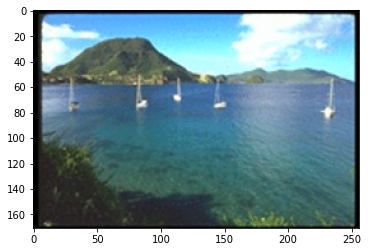

239.0625


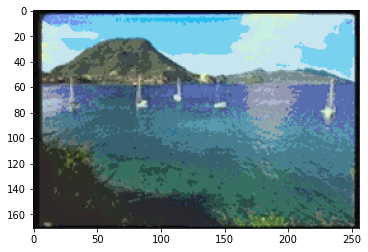

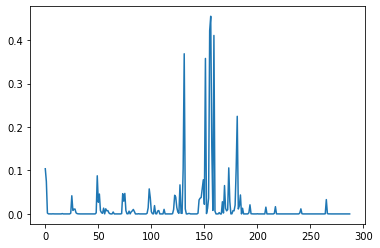

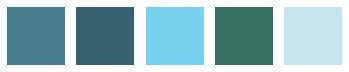

[(5, 2, 7), (7, 2, 7), (8, 0, 4), (8, 0, 5), (8, 0, 6)]


In [51]:
PathImage = './Base/'  # to be completed

def Representation(nom,nH,nS,nV):
    """Permet d'afficher la représention complète d'une image"""


    filename= nom;
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]
    plt.figure();
    plt.imshow(I);
    plt.show()

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors( nH, nS , nV );

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    viewQuantizedImage(Iq , palette2)

    # flat a 3D histogram to 1D
    histo = histo.flat

    # Histogram normalization (your function)
    histo = normalize(histo)

    plt.figure()
    plt.plot(histo)
    plt.show()

    ## Determine 5 more frequent colors
    idx_most_prevalent = (histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

    display5mainColors(histo, palette)

    print(hsv_most_prevalent)

Representation("Paysages67.png",12,3,8)

6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

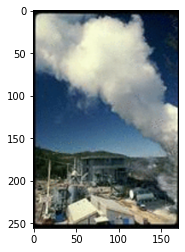

229.5


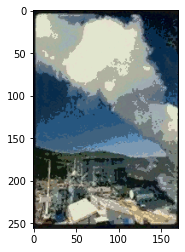

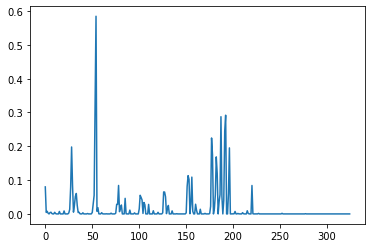

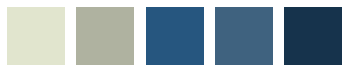

[(6, 2, 2), (8, 1, 2), (8, 1, 3), (8, 1, 4), (8, 2, 2)]


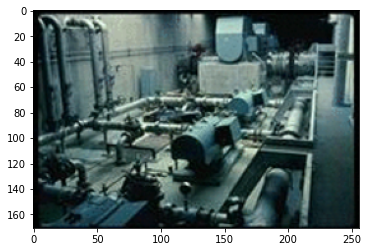

245.1923076923077


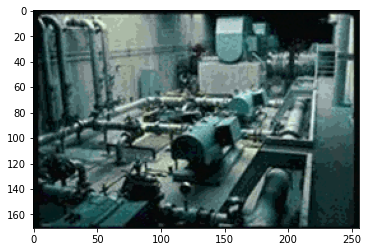

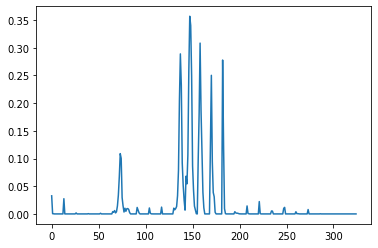

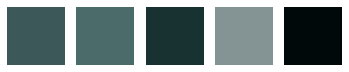

[(4, 4, 12), (2, 2, 9), (2, 2, 10), (2, 2, 11), (2, 2, 12)]


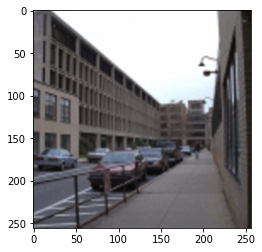

229.5


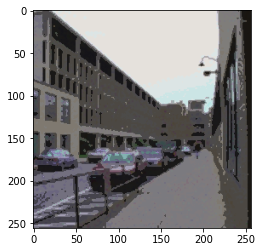

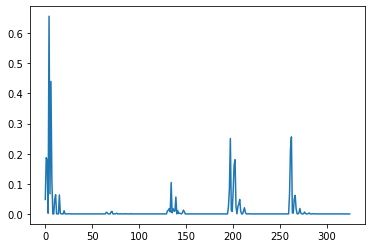

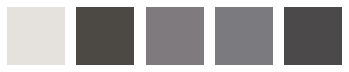

[(2, 6, 2), (2, 11, 0), (2, 11, 1), (2, 11, 2), (2, 11, 3)]


In [56]:
Representation("Paysages64.png",13,5,5)
Representation("Paysages62.png",5,5,13)
Representation("Paysages68.png",5,13,5)

7) What can you say about the results?

**On peut voir que les paramètres nH,nS et nV influence drastiquement l'analyse de l'image. En effet, en jouant avec ces paramètres on peux plus ou moins exprimer certaines couleurs pour une analyse d'image plus pointue.**

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [59]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
listImage = os.listdir(pathImage)
pathDescriptors = './'

# Quantization HSV
nH = 13
nS = 4
nV = 9

bcomputed = False # Set to False to compute the histogramm database

if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation ... it may take a while ...
Aeriennes10.png
Aeriennes11.png
Aeriennes12.png
Aeriennes13.png
Aeriennes14.png
Aeriennes15.png
Aeriennes16.png
Aeriennes17.png
Aeriennes18.png
Aeriennes19.png
Aeriennes20.png
Aeriennes21.png
Aeriennes22.png
Aeriennes23.png
Aeriennes24.png
Aeriennes25.png
Aeriennes26.png
Aeriennes27.png
Aeriennes28.png
Aeriennes29.png
Aeriennes30.png
Aeriennes31.png
Avions1.png
Avions10.png
Avions100.png
Avions101.png
Avions11.png
Avions12.png
Avions13.png
Avions14.png
Avions15.png
Avions16.png
Avions17.png
Avions18.png
Avions19.png
Avions2.png
Avions20.png
Avions21.png
Avions22.png
Avions23.png
Avions24.png
Avions25.png
Avions26.png
Avions27.png
Avions28.png
Avions29.png
Avions3.png
Avions30.png
Avions31.png
Avions32.png
Avions33.png
Avions34.png
Avions35.png
Avions36.png
Avions37.png
Avions38.png
Avions39.png
Avions4.png
Avions40.png
Avions41.png
Avions42.png
Avions43.png
Avions44.png
Avions45.png
Avions46.png
Avions47.png
Avions48.png
Avions

### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [60]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

### you code below

def similarityMatrix(listHisto):
    S = np.zeros((len(listHisto),len(listHisto)))
    
    for i in range(len(listHisto)):
        for j in range(len(listHisto)):
            "S[i,j] = np.linalg.norm(listHisto[i]-listHisto[j],2)"
            #Personnellement je n'ai pas trouver de résultat avec une autre formule.
            #J'ai donc tenter d'utiliser le produit scalaire comme indiquer dans le cours.
            S[i,j] = np.dot(listHisto[i],listHisto[j])
    return S

S = similarityMatrix(listHisto)

[[1.         0.68534603 0.62278585 ... 0.0482242  0.02696523 0.14408321]
 [0.68534603 1.         0.33011664 ... 0.02481082 0.00801633 0.09642818]
 [0.62278585 0.33011664 1.         ... 0.17328876 0.0835554  0.18372372]
 ...
 [0.0482242  0.02481082 0.17328876 ... 1.         0.41632546 0.01794175]
 [0.02696523 0.00801633 0.0835554  ... 0.41632546 1.         0.01155548]
 [0.14408321 0.09642818 0.18372372 ... 0.01794175 0.01155548 1.        ]]


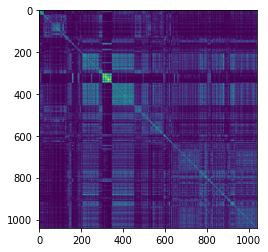

In [61]:
print(S)

plt.imshow(S)
plt.show()

2. Display the matrix `S`  as an image. What can we say about this it ?

On peux voir une ligne en diagonale qui représente la valeur 1 ( ou 0 selon la formule ) lorsque l'on faire la comparaison de similitude de la même image. On observe également des bande de couleur plus ou moins sombre, des valeur plus élevé, car les image sont les plus similaires dans cette partie.

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

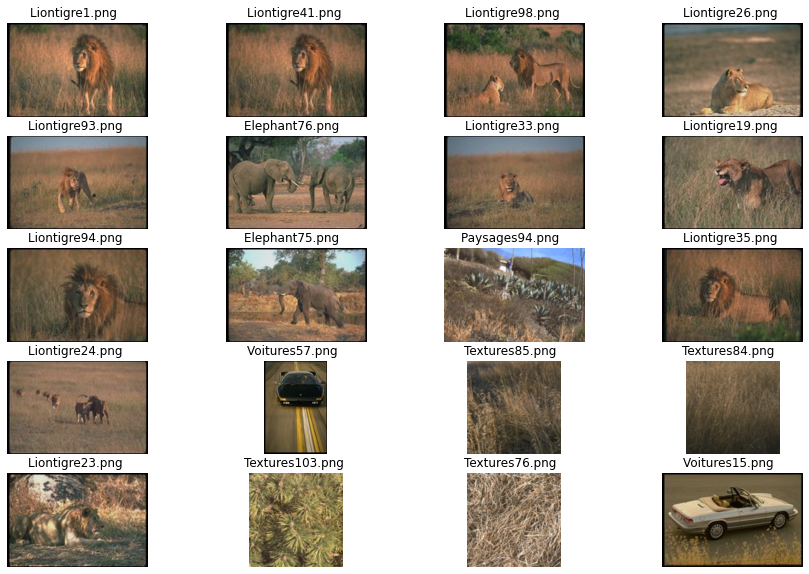

In [62]:
indexQuery = np.where(listImage=="Liontigre1.png  ")[0][0]
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()


On peux voir que nous avons retrouvée une majorité de lion ce qui n'est pas si mal. De plus les autres images contiennent des éléments de savane comme les textures trouvé. Les éléments qui montre le plus que le systeme n'est pas sans faille sont leux deux clichés de voiture en particulier la voiture noire ( Voiture 57 ) qui ne semble pas avoir d'importante couleurs significatives en commun avec notre photo de référence.

4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


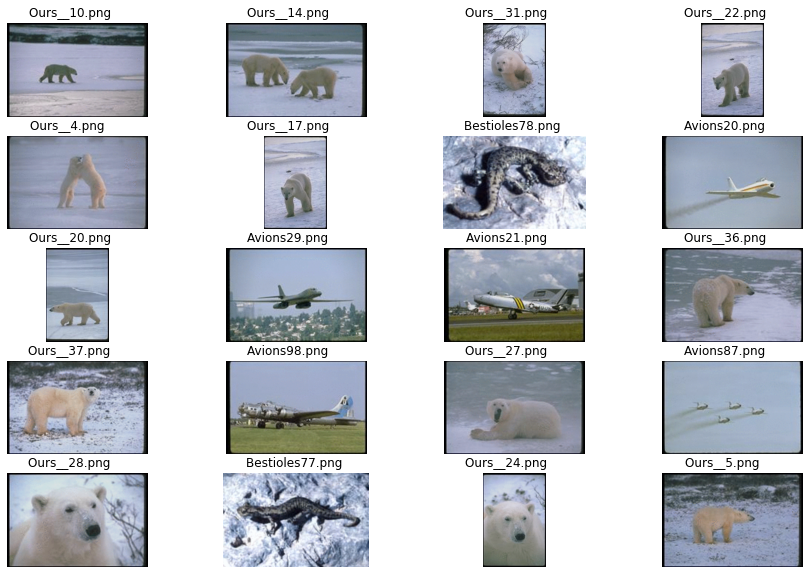

In [20]:
import random

indexQuery = random.randint(0,1031)
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()


5. What can you say about the results ? What are the limitations and the advantages of this method ?

Les résultats sont variée et peuvent etre très bon comme très mauvais. En effet, pour que la recherche sois efficace, les paramètres ns,nh et nv doivent etre adapté a la base elle même, ici notre base de données est peux etre trop éparse ou bien les paramètre ne sont pas correct pour retrouver les photos similaire. 